In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import rasterio as rio
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, richardson_lucy
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from src.denoising import denoise_swt, apply_wavelet, apply_tv
from src.ecs import ECS
from src.segmentation import segment2d, segment_metrics

In [2]:
def load_all_startswith(directory, starts_with):
    files = [directory + "/" + f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f)) and f.startswith(starts_with)]
    def extract_number(s):
        match = re.search(r'\d+', s)
        return int(match.group()) if match else float('inf')
    
    sorted_files = sorted(files, key=extract_number)

    X = []
    for i in sorted_files:
        temp = rio.open(i)
        X.append(temp.read())
        temp.close()
    X = np.concatenate(X)

    return X

In [3]:
scaled = load_all_startswith('data/scaled', 'scaled')
optimized = load_all_startswith('data/optimized', 'optimized')

In [4]:
scaled = scaled[:,:,:-3]
optimized = optimized[:,:,:-3]

In [55]:
def add_noise(img, std_dev=1, avg=0):
    noise = np.random.normal(avg, std_dev, img.shape)
    noised = np.add(img, noise)
    return noised

In [73]:
original = scaled[0]
example = add_noise(original, 0.5)
noisy_wav = denoise_swt(example)
noisy_tv = denoise_tv_chambolle(example, weight=0.2)
noisy_bil = denoise_bilateral(example)
noisy_nlm = denoise_nl_means(example)

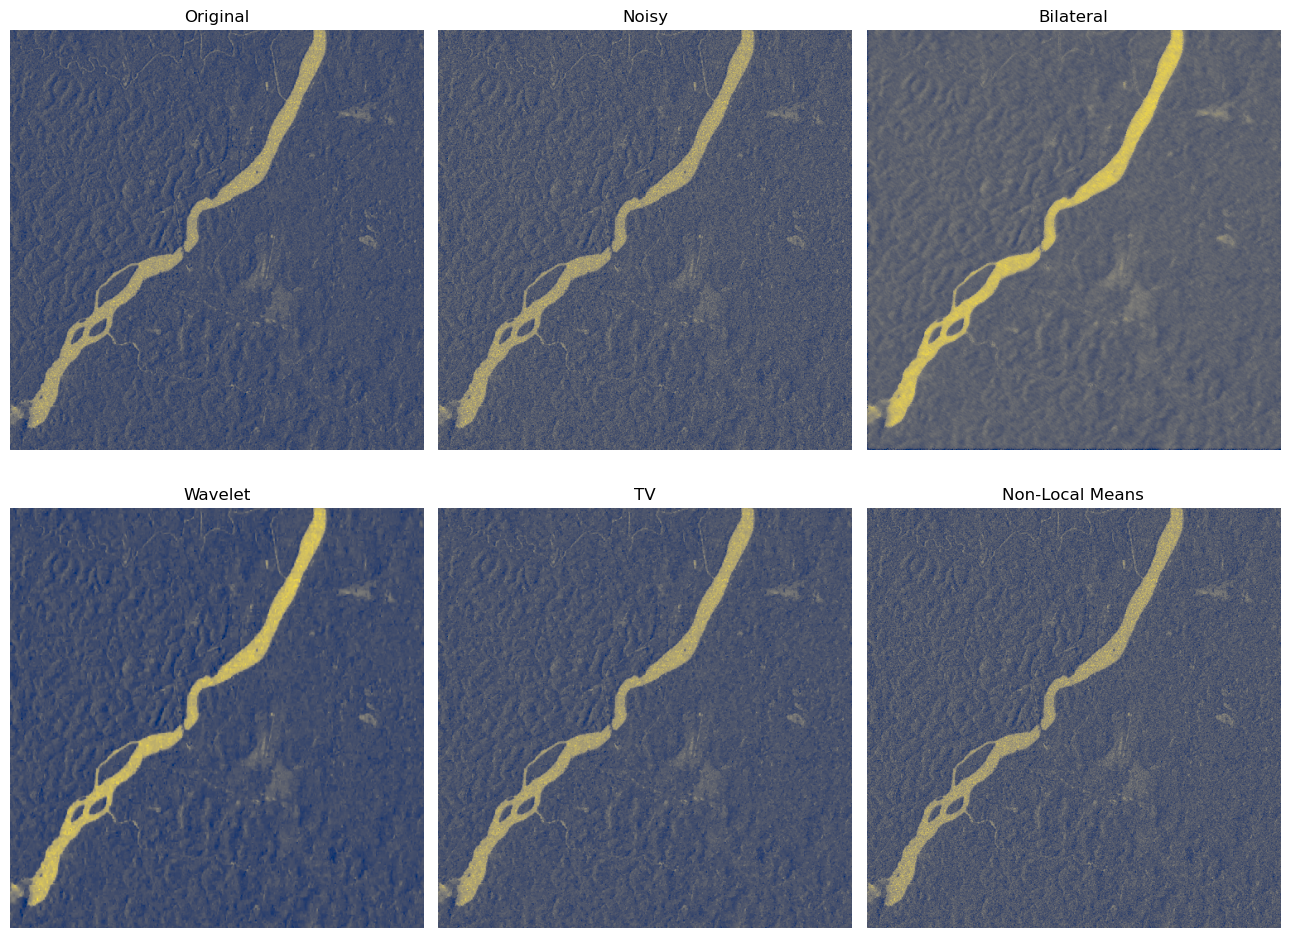

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(13, 10))

palette = 'cividis'

axes[0, 0].imshow(original, cmap=palette)
axes[0, 0].set_title("Original")
axes[0, 0].set_axis_off()

axes[0, 1].imshow(example, cmap=palette)
axes[0, 1].set_title("Noisy")
axes[0, 1].set_axis_off()

axes[1, 0].imshow(noisy_wav, cmap=palette)
axes[1, 0].set_title("Wavelet")
axes[1, 0].set_axis_off()

axes[1, 1].imshow(noisy_tv, cmap=palette)
axes[1, 1].set_title("TV")
axes[1, 1].set_axis_off()

axes[0, 2].imshow(noisy_bil, cmap=palette)
axes[0, 2].set_title("Bilateral")
axes[0, 2].set_axis_off()

axes[1, 2].imshow(noisy_nlm, cmap=palette)
axes[1, 2].set_title("Non-Local Means")
axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
ssim_wav = structural_similarity(original, noisy_wav, data_range=noisy_wav.max() - noisy_wav.min())
ssim_tv = structural_similarity(original, noisy_tv, data_range=noisy_tv.max() - noisy_tv.min())
ssim_bil = structural_similarity(original, noisy_bil, data_range=noisy_bil.max() - noisy_bil.min())
ssim_nlm = structural_similarity(original, noisy_nlm, data_range=noisy_nlm.max() - noisy_nlm.min())

print('SSim Wavelet: ', str(ssim_wav), '\nSSim TV: ', str(ssim_tv), '\nSSim Bilateral: ', str(ssim_bil), '\nSSim Non-Local Means: ', str(ssim_nlm))

SSim Wavelet:  0.5928823843309016 
SSim TV:  0.739960022410511 
SSim Bilateral:  0.39355722612475397 
SSim Non-Local Means:  0.6723937537945456


In [78]:
psnr_wav = peak_signal_noise_ratio(noisy_wav, example, data_range=noisy_wav.max() - noisy_wav.min())
psnr_tv = peak_signal_noise_ratio(noisy_tv, example, data_range=noisy_tv.max() - noisy_tv.min())
psnr_bil = peak_signal_noise_ratio(noisy_bil, example, data_range=noisy_bil.max() - noisy_bil.min())
psnr_nlm = peak_signal_noise_ratio(noisy_nlm, example, data_range=noisy_nlm.max() - noisy_nlm.min())

print('PSNR Wavelet: ', str(psnr_wav), '\nPSNR TV: ', str(psnr_tv), '\nPSNR Bilateral: ', str(psnr_bil), '\nPSNR Non-Local Means: ', str(psnr_nlm))

PSNR Wavelet:  22.34716653045342 
PSNR TV:  28.85980034714902 
PSNR Bilateral:  22.116463236680342 
PSNR Non-Local Means:  351.30683242489766
